In [253]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import requests
from nltk.corpus import stopwords as nltk_stopwords
from string import punctuation
from kneed.knee_locator import KneeLocator
from matplotlib import pyplot as plt
import nltk
import re


# Endereço da API dos comentários do wikilegis
BABEL_API_URL = 'https://babel.labhackercd.leg.br/api/v1/manifestations?manifestation_type__id=3'

# Pegando comentários da API do Babel
data = requests.get(BABEL_API_URL).json()['results']
for i in range(2, 11):
    data += requests.get(BABEL_API_URL + '&page=%s' % i).json()['results']

comments = [comment['content'] for comment in data]

stopwords = nltk_stopwords.words('portuguese') + list(punctuation)

In [242]:
stemmer = nltk.RSLPStemmer()
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    stems = [stemmer.stem(t) for t in tokens]
    return list(set(stems))

In [255]:
stopwords = nltk_stopwords.words('portuguese') + list(punctuation)
stem_stopwords = [stemmer.stem(word) for word in stopwords]

In [293]:
vectorizer = TfidfVectorizer(stop_words=stem_stopwords, tokenizer=tokenize_and_stem, analyzer='word',
                             ngram_range=(1, 3), max_df=0.7, min_df=0.2)

X = vectorizer.fit_transform(comments)

/home/erivanio/anaconda3/envs/jupyenv/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``', 'es', 'estivés', 'fos', 'fôs', 'houvés', 'is', 'nos', 'tivés'] not in stop_words.
  sorted(inconsistent))


In [294]:
distortions = []
X = vectorizer.fit_transform(comments)
K = range(2, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X.toarray(), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

8


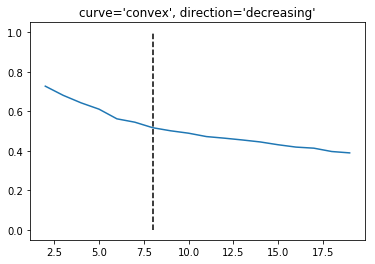

In [295]:
# find the knee points
kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')

# plot
plt.plot(K, distortions)
plt.vlines(x=kn.knee, ymin=0, ymax=1, linestyle='--')
plt.title("curve='convex', direction='decreasing'")

print(kn.knee)

In [292]:
true_k = 8
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

print("\n")
print("Prediction")

Y = vectorizer.transform(["Agora entendi, joseivanaquino. Inviável para 2017 pelo tempo de adaptação..."])
prediction = model.predict(Y)
print(prediction)

Y = vectorizer.transform(["Todas as disciplinas devem continuar obrigatórias e ainda ser adicionado o estudo da cidadania, para que os alunos estudem a constituição, leis, direitos e deveres. E política, para obterem uma visão mais crítica sobre os governantes, em quem votar, como a política funciona, como entrar nos portais do governo como este para participarem mais da democracia."])
prediction = model.predict(Y)
print(prediction)

Top terms per cluster:
Cluster 0:
 dev
 prev
 exclus
 incis
 dest
 suger
 artig
 art
 parágraf
 dad
Cluster 1:
 parágraf
 pod
 apen
 dest
 lei
 red
 compet
 estabelec
 art
 exclus
Cluster 2:
 ativ
 órg
 ii
 lei
 determin
 públic
 i
 pod
 aind
 artig
Cluster 3:
 é
 empr
 acredit
 necess
 pod
 tod
 precis
 dad
 defin
 nest
Cluster 4:
 dad trat
 trat
 dad
 pessoal
 suger
 text
 dev
 titul
 consent
 é
Cluster 5:
 text
 suger
 titul
 i
 trat
 inform
 consent
 dev
 ii
 art
Cluster 6:
 direit
 dev
 titul
 proteç
 é
 vist
 ”
 “
 dad
 pod
Cluster 7:
 incis
 públic
 suger
 geral
 dad
 trat
 titul
 inform
 dev
 ativ


Prediction
[1]
[6]
